In [1]:
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sys
import time
import numpy as np
import math
import pandas as pd
from PIL import Image, ImageOps, ImageFilter
from datetime import datetime
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
import random
import datetime
import os

from sklearn import preprocessing 
from sklearn.model_selection import KFold

import torch.optim.lr_scheduler


import torch
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
import os
from PIL import Image
import numpy as np
print(torch.__version__)

1.3.0


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
import numpy as np
import json
datanumber = 1800

In [4]:
with open ('dataset_ver2/combine.json','r',encoding="utf-8") as data:
    test=json.load(data)
    train_data = []
    label_data = []
    for i in range(datanumber):
        #print("-----------------")
        #print("location: train",test[i]["location"])
        #print("fans_number:",test[i]["fans_number"])
        #print("likes:",test[i]["likes"])
        #print("comment_number",test[i]["comment_number"])
        train_data.append([test[i]["location"]])
        #print(int(test[i]["likes"])/int(test[i]["fans_number"]))
        if int(test[i]["likes"])/(test[i]["fans_number"]/1000) >29:
            a=np.eye(40,k=29)[0]
        else:
            a=np.eye(40,k=int(int(test[i]["likes"])/(int(test[i]["fans_number"])/1000)))[0]
        if int(test[i]["comment_number"])/50 >9:
            b=np.eye(40,k=39)[0]
        else:
            b=np.eye(40,k=(int(int(test[i]["comment_number"])/50)+30))[0]
        train_data.append(a+b)
        #print((a+b).shape)

In [5]:
train_data_array = np.array(train_data)
train_data_array = train_data_array.reshape(datanumber,2)
#print(train_data_array)

random.shuffle(train_data_array)

In [6]:
print(train_data_array.shape)
print(train_data_array[:,0])

(1800, 2)
[list(['train/0.jpg']) list(['train/0.jpg']) list(['train/0.jpg']) ...
 list(['train/604.jpg']) list(['test/345.jpg']) list(['test/1798.jpg'])]


In [7]:
train_data = train_data_array[:1500]
test_data = train_data_array[1500:1800]

In [8]:
def onehot(length, num):
    d = np.zeros(length)
    d[num] = 1
    return d

In [9]:
# load the image transformer
centre_crop = trn.Compose([
        trn.Resize((256,256)),
        trn.CenterCrop(224),
        trn.ToTensor(),
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [10]:
class dataset(Dataset):
    def __init__(self, data_arr, transform):
        self.filenames = data_arr[:,0]
        self.labels = data_arr[:,1]
        #self.filenames = data_dir[:,0]
        #self.labels = data_dir[:,1]
        self.transform = transform

    def __len__(self):
        # return size of dataset
        return len(self.filenames)

    def __getitem__(self, idx):
        image = Image.open("dataset_ver2/"+self.filenames[idx][0])  # PIL image
        #image = Image.open(self.filenames[idx]).convert('LA')  # PIL image
        #image = ImageOps.equalize(image, mask = None)
        image = self.transform(image)
        return image,self.labels[idx]

In [11]:

train_dataloader = DataLoader(dataset(train_data,centre_crop),
                               batch_size=16, 
                               shuffle=True,
                               num_workers=2, 
                               pin_memory=True)

test_dataloader = DataLoader(dataset(test_data,centre_crop),
                               batch_size=16, 
                               shuffle=True,
                               num_workers=2, 
                               pin_memory=True)

In [12]:
print("Train data: ",len(dataset(train_data,centre_crop)))
print("Test data: ",len(dataset(test_data,centre_crop)))

Train data:  1500
Test data:  300


18
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


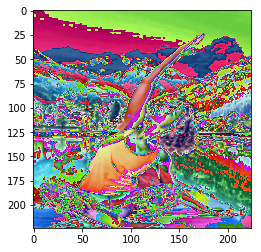

In [13]:
index = 8
plt.imshow(transforms.ToPILImage()(train_dataloader.dataset[index][0]).convert('RGB'))

print(np.argmax(train_dataloader.dataset.labels[index]))
print(train_dataloader.dataset.labels[index])

In [14]:
# th architecture to use
arch = 'resnet18'

# load the pre-trained weights
model_file = '%s_places365.pth.tar' % arch
if not os.access(model_file, os.W_OK):
    weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_file
    os.system('wget ' + weight_url)

In [15]:
model = models.__dict__[arch](num_classes=365)
checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
model.load_state_dict(state_dict)
model.eval()
#print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
for i in model.children():
    i.requires_grad = False

# model.fc = torch.nn.Linear(in_features=512, out_features=40, bias=True)

model.fc =  torch.nn.Sequential(
            torch.nn.Linear(in_features=512, out_features=128, bias=True),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(in_features=128, out_features=40, bias=True))

model.fc.requires_grad = True
print(model)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
# load the class label
file_name = 'categories_places365.txt'
if not os.access(file_name, os.W_OK):
    synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt'
    os.system('wget ' + synset_url)
classes = list()
with open(file_name) as class_file:
    for line in class_file:
        classes.append(line.strip().split(' ')[0][3:])
classes = tuple(classes)

#print(np.array(classes))

In [18]:
class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        # Inspired by the implementation of binary_cross_entropy_with_logits
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})".format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + ((-max_val).exp() + (-input - max_val).exp()).log()

        # This formula gives us the log sigmoid of 1-p if y is 0 and of p if y is 1
        invprobs = F.logsigmoid(-input * (target * 2 - 1))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.mean()

In [19]:
optimizer = torch.optim.SGD(model.parameters(),lr=0.005)
# loss_func = nn.CrossEntropyLoss()
loss_func = FocalLoss(0.4)

In [20]:
def train(epoch,dloader):
    for step, (x,y) in enumerate(dloader):
        data = Variable(x).cuda()   # batch x
        #data2 = Variable(x2).cuda()
        target = Variable(y).cuda()   # batch y

        output = model(data)

        loss = loss_func(output, target.float())   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients
        if step==0:
            start = time.time()
            #break
            ti = 0
        elif step==50:
            ti = time.time()-start #total time = ti*(length/100)
            #print(ti)
            ti = ti*(len(dloader)/50)
        if step % 50 == 0:
            second = ti*(((len(dloader)-step)/len(dloader)))#*(5-epoch)*(4-fnum)
            print('Ep: {} [{}/{} ({:.0f}%)]\t Loss: {:.6f}\t Remain : {} '.
                     format(epoch+1, 
                            step * len(data), 
                            len(dloader.dataset),
                            50.*step/len(dloader), 
                            loss.data.item(),
                            datetime.timedelta(seconds = int(second))))
        data.cpu()
        #data2.cpu()
        target.cpu()
        torch.cuda.empty_cache()
    print("Finish")

In [21]:
def val(dloader):
    los = []
    for step, (x, y) in enumerate(dloader):
        data = Variable(x).cuda()
        target = Variable(y).cuda()
        with torch.no_grad():
            output = model(data)
        
        loss = loss_func(output, target.float())
        los.append(loss.item())

        if step %50 == 0:
            print('[{}/{} ({:.1f}%)]'.format(step * len(data), 
                                        len(dloader.dataset),
                                        50.*step/len(dloader)))
        data.cpu()
        #data2.cpu()
        target.cpu()
        torch.cuda.empty_cache()
    los = np.array(los)
    avg_val_loss = los.sum()/len(los)
    print("Avg val loss: avg_val_loss {:.8f}".format(loss))


In [22]:
Epoch = 10
for epoch in range(Epoch):
    if epoch < (5):
        optimizer = torch.optim.Adam(model.parameters(),lr=0.005)
    elif epoch >= (5) and epoch < (10) :
        optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
    else:
        optimizer = torch.optim.Adam(model.parameters(),lr=0.0005)
    train(epoch, train_dataloader)
    val(test_dataloader)

Ep: 1 [0/1500 (0%)]	 Loss: 0.521484	 Remain : 0:00:00 
Ep: 1 [800/1500 (27%)]	 Loss: 0.065315	 Remain : 0:00:12 
Finish
[0/300 (0.0%)]
Avg val loss: avg_val_loss 0.04955792
Ep: 2 [0/1500 (0%)]	 Loss: 0.070157	 Remain : 0:00:00 
Ep: 2 [800/1500 (27%)]	 Loss: 0.078895	 Remain : 0:00:12 
Finish
[0/300 (0.0%)]
Avg val loss: avg_val_loss 0.08048841
Ep: 3 [0/1500 (0%)]	 Loss: 0.061682	 Remain : 0:00:00 
Ep: 3 [800/1500 (27%)]	 Loss: 0.064333	 Remain : 0:00:12 
Finish
[0/300 (0.0%)]
Avg val loss: avg_val_loss 0.07174632
Ep: 4 [0/1500 (0%)]	 Loss: 0.052711	 Remain : 0:00:00 
Ep: 4 [800/1500 (27%)]	 Loss: 0.067264	 Remain : 0:00:11 
Finish
[0/300 (0.0%)]
Avg val loss: avg_val_loss 0.07303870
Ep: 5 [0/1500 (0%)]	 Loss: 0.038822	 Remain : 0:00:00 
Ep: 5 [800/1500 (27%)]	 Loss: 0.058037	 Remain : 0:00:11 
Finish
[0/300 (0.0%)]
Avg val loss: avg_val_loss 0.06664389
Ep: 6 [0/1500 (0%)]	 Loss: 0.075621	 Remain : 0:00:00 
Ep: 6 [800/1500 (27%)]	 Loss: 0.045970	 Remain : 0:00:12 
Finish
[0/300 (0.0%)]


In [23]:
# # load the test image
# img_name = '12.jpg'
# if not os.access(img_name, os.W_OK):
#     img_url = 'http://places.csail.mit.edu/demo/' + img_name
#     os.system('wget ' + img_url)

# img = Image.open(img_name)
# input_img = V(centre_crop(img).unsqueeze(0))

# # forward pass
# logit = model.forward(input_img)

# #print(logit)
# h_x = F.softmax(logit, 1).data.squeeze()

# probs, idx = h_x.sort(0, True)

In [24]:
# print('{} prediction on {}'.format(arch,img_name))
# # output the prediction
# for i in range(0, 5):
#     print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))
#     print(idx[i])


In [25]:
model.cpu().eval()
example = torch.rand(1, 3, 256, 256)
traced_script_module = torch.jit.trace(model, example)
traced_script_module.save("model_scope.pt")